In [1]:
import numpy as  np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers


In [2]:
df=pd.read_csv('https://api.covid19india.org/csv/latest/case_time_series.csv')
df

,Date,Date_YMD,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased
0,30 January 2020,2020-01-30,1,1,0,0,0,0
1,31 January 2020,2020-01-31,0,1,0,0,0,0
2,1 February 2020,2020-02-01,0,1,0,0,0,0
3,2 February 2020,2020-02-02,1,2,0,0,0,0
4,3 February 2020,2020-02-03,1,3,0,0,0,0
...,...,...,...,...,...,...,...,...
458,2 May 2021,2021-05-02,370090,19919645,300004,16281710,3423,218356
459,3 May 2021,2021-05-03,355769,20275414,318910,16600620,3439,221795
460,4 May 2021,2021-05-04,382847,20658261,337699,16938319,3786,225581
461,5 May 2021,2021-05-05,412624,21070885,330718,17269037,3979,229560


In [3]:
df.shape

(463, 8)

In [4]:
df1=df

In [5]:
def Recovery_Rate(RC,CC):
  return (RC/CC)*100

In [6]:
RR=[]
for i in df.index:
  RR.append(Recovery_Rate(df['Total Recovered'][i], df['Total Confirmed'][i]))

In [7]:
df1['Recovery Rate']=RR

In [8]:
def Case_Load_Rate(CC,RC,D):
  CaseLoad=CC-RC-D
  return (CaseLoad/CC)*100
  # return CaseLoad

In [9]:
CLR=[]
for i in df.index:
  CLR.append(Case_Load_Rate(df['Daily Confirmed'][i],df['Daily Recovered'][i],  df['Daily Deceased'][i]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
df1['Case Load Rate']=CLR

In [11]:
def Delta(CLR,RR):
  return CLR-RR

In [12]:
Del=[]
for i in df.index:
  Del.append(Delta(df1['Case Load Rate'][i],df1['Recovery Rate'][i]))

In [13]:
df1['Delta']=Del

In [14]:
df1

,Date,Date_YMD,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased,Recovery Rate,Case Load Rate,Delta
0,30 January 2020,2020-01-30,1,1,0,0,0,0,0.000000,100.000000,100.000000
1,31 January 2020,2020-01-31,0,1,0,0,0,0,0.000000,NaN,NaN
2,1 February 2020,2020-02-01,0,1,0,0,0,0,0.000000,NaN,NaN
3,2 February 2020,2020-02-02,1,2,0,0,0,0,0.000000,100.000000,100.000000
4,3 February 2020,2020-02-03,1,3,0,0,0,0,0.000000,100.000000,100.000000
...,...,...,...,...,...,...,...,...,...,...,...
458,2 May 2021,2021-05-02,370090,19919645,300004,16281710,3423,218356,81.736949,18.012646,-63.724303
459,3 May 2021,2021-05-03,355769,20275414,318910,16600620,3439,221795,81.875615,9.393736,-72.481880
460,4 May 2021,2021-05-04,382847,20658261,337699,16938319,3786,225581,81.992957,10.803794,-71.189163
461,5 May 2021,2021-05-05,412624,21070885,330718,17269037,3979,229560,81.956866,18.885717,-63.071149


In [15]:
train_dates=pd.to_datetime(df['Date_YMD'])

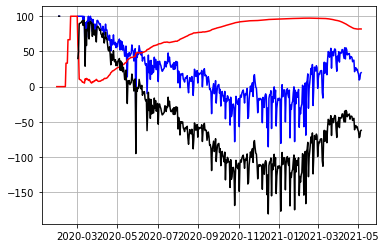

In [16]:
# plt.title("Red - Recovery Rate Blue - Case Load Rate Black-Delta")
plt.plot(train_dates,CLR,color="Blue", Label='Case Load Rate')
plt.plot(train_dates,RR,color="red", Label='Recovery Rate')
plt.plot(train_dates,Del,color="Black", Label='Delta')
plt.grid()

In [17]:
cols=list(df1)[9:10]
cols

['Case Load Rate']

In [18]:
df1.replace([np.inf, -np.inf], np.nan, inplace=True)
df1.dropna(inplace=True)

In [19]:
df_for_training=df1[cols].astype(float)

In [20]:
scaler=StandardScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled=scaler.transform(df_for_training)

In [22]:
df_for_training_scaled

array([[ 2.06886527e+00],
       [ 2.06886527e+00],
       [ 2.06886527e+00],
       [ 2.06886527e+00],
       [ 2.06886527e+00],
       [ 2.06886527e+00],
       [ 2.06886527e+00],
       [ 2.06886527e+00],
       [ 2.06886527e+00],
       [ 2.06886527e+00],
       [ 2.06886527e+00],
       [ 1.89530672e+00],
       [ 2.06886527e+00],
       [ 1.80852745e+00],
       [ 5.06838358e-01],
       [ 1.83219452e+00],
       [ 1.28785181e+00],
       [ 1.88290968e+00],
       [ 1.80852745e+00],
       [ 2.06886527e+00],
       [ 1.49033678e+00],
       [ 1.93420778e+00],
       [ 2.06886527e+00],
       [ 1.95567491e+00],
       [ 1.95808322e+00],
       [ 1.50597269e+00],
       [ 1.94777791e+00],
       [ 1.64091269e+00],
       [ 1.59243004e+00],
       [ 1.78172797e+00],
       [ 1.63496890e+00],
       [ 1.38669665e+00],
       [ 1.90878700e+00],
       [ 1.91536420e+00],
       [ 1.86530895e+00],
       [ 1.82247412e+00],
       [ 1.75861813e+00],
       [ 1.79100060e+00],
       [ 1.6

In [23]:
trainX=[]
trainY=[]

In [24]:
n_future=1
n_past=14

In [25]:
for i in range(n_past, len(df_for_training_scaled)-n_future +1):
  trainX.append(df_for_training_scaled[i-n_past:i, 0:df_for_training.shape[1]])
  trainY.append(df_for_training_scaled[i+n_future-1:i+n_future,0])
trainX,trainY=np.array(trainX),np.array(trainY)

In [26]:
trainX

array([[[ 2.06886527],
        [ 2.06886527],
        [ 2.06886527],
        ...,
        [ 1.80852745],
        [ 2.06886527],
        [ 1.49033678]],

       [[ 2.06886527],
        [ 2.06886527],
        [ 2.06886527],
        ...,
        [ 2.06886527],
        [ 1.49033678],
        [ 1.93420778]],

       [[ 2.06886527],
        [ 2.06886527],
        [ 2.06886527],
        ...,
        [ 1.49033678],
        [ 1.93420778],
        [ 2.06886527]],

       ...,

       [[ 0.8985625 ],
        [ 0.83668777],
        [ 0.63910123],
        ...,
        [-0.00264459],
        [-0.06557563],
        [-0.28995845]],

       [[ 0.83668777],
        [ 0.63910123],
        [ 0.68681703],
        ...,
        [-0.06557563],
        [-0.28995845],
        [-0.25324931]],

       [[ 0.63910123],
        [ 0.68681703],
        [ 0.67477893],
        ...,
        [-0.28995845],
        [-0.25324931],
        [-0.04284629]]])

In [28]:

model=Sequential()
model.add(LSTM(units=64,return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=128,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=128,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=1))
model.compile(optimizer = 'Adam', loss='mean_squared_error', metrics=['mean_squared_error','mean_absolute_error'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 21, 64)            16896     
_________________________________________________________________
dropout (Dropout)            (None, 21, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 21, 128)           98816     
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 21, 128)           131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 21, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 21, 128)           1

In [30]:
history=model.fit(trainX,trainY,epochs=90,batch_size=1,validation_split=0.2,verbose=1)

Epoch 1/90
330/330 [==============================] - 21s 42ms/step - loss: 0.3670 - mean_squared_error: 0.3670 - mean_absolute_error: 0.4368 - val_loss: 0.2901 - val_mean_squared_error: 0.2901 - val_mean_absolute_error: 0.4394
Epoch 2/90
330/330 [==============================] - 11s 35ms/step - loss: 0.3574 - mean_squared_error: 0.3574 - mean_absolute_error: 0.4421 - val_loss: 0.3067 - val_mean_squared_error: 0.3067 - val_mean_absolute_error: 0.4757
Epoch 3/90
330/330 [==============================] - 11s 34ms/step - loss: 0.3254 - mean_squared_error: 0.3254 - mean_absolute_error: 0.4120 - val_loss: 0.3223 - val_mean_squared_error: 0.3223 - val_mean_absolute_error: 0.4714
Epoch 4/90
330/330 [==============================] - 12s 36ms/step - loss: 0.1991 - mean_squared_error: 0.1991 - mean_absolute_error: 0.3227 - val_loss: 0.4187 - val_mean_squared_error: 0.4187 - val_mean_absolute_error: 0.5492
Epoch 5/90
330/330 [==============================] - 12s 36ms/step - loss: 0.2746 - mea

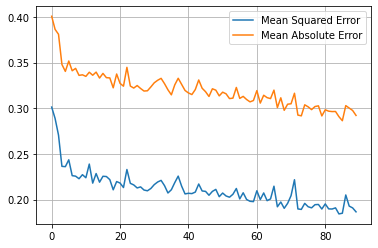

In [31]:
plt.plot(history.history['mean_squared_error'], Label='Mean Squared Error')
plt.plot(history.history['mean_absolute_error'], Label='Mean Absolute Error')
plt.grid()
plt.legend()

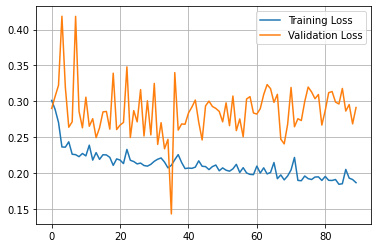

In [32]:
plt.plot(history.history['loss'], Label='Training Loss')
plt.plot(history.history['val_loss'], Label='Validation Loss')
plt.grid()
plt.legend()

In [38]:
n_f=60
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_f, freq='1d').tolist()
forecast = model.predict(trainX[-n_f:])
forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]


forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

In [34]:
forecast_dates

[datetime.date(2021, 5, 6),
 datetime.date(2021, 5, 7),
 datetime.date(2021, 5, 8),
 datetime.date(2021, 5, 9),
 datetime.date(2021, 5, 10),
 datetime.date(2021, 5, 11),
 datetime.date(2021, 5, 12),
 datetime.date(2021, 5, 13),
 datetime.date(2021, 5, 14),
 datetime.date(2021, 5, 15),
 datetime.date(2021, 5, 16),
 datetime.date(2021, 5, 17),
 datetime.date(2021, 5, 18),
 datetime.date(2021, 5, 19),
 datetime.date(2021, 5, 20)]

In [39]:
df_forecast = pd.DataFrame({'Date_YMD':np.array(forecast_dates), 'Case Load Rate':y_pred_future})
df_forecast['Date_YMD']=pd.to_datetime(df_forecast['Date_YMD'])

In [40]:
original=df1[['Date_YMD','Case Load Rate']]
original['Date_YMD']=pd.to_datetime(original['Date_YMD'])
original = original.loc[original['Date_YMD'] >= '2020-01-30']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


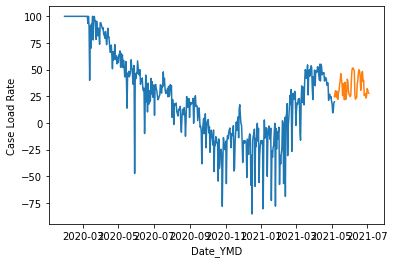

In [41]:
sns.lineplot(original['Date_YMD'], original['Case Load Rate'])
sns.lineplot(df_forecast['Date_YMD'], df_forecast['Case Load Rate'])